# Searching for hotspots in the two-circle dataset

This notebook implements an example analysis of hotspot detection for the mapper algorithm. 

In [1]:
%matplotlib inline
from sklearn.datasets import make_circles
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sklearn.cluster as sklc
import hotmapper.mapper as hm
import hotmapper.utils as hmu
import hotmapper.hotspot as hmh
import hotmapper.parameter_search as hps
import hotmapper.feature_combination_lens as hfcl
import csv


## Data 

We generate an 2-D example of two concentric circles, downloaded from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html). We want to be able to generate a Mapper graph that represents the core structural features of this dataset (two disconnected loops). 

In [2]:
#import dataset
X, y = make_circles(n_samples=5000, noise=0.03, factor=0.3, random_state = 123)

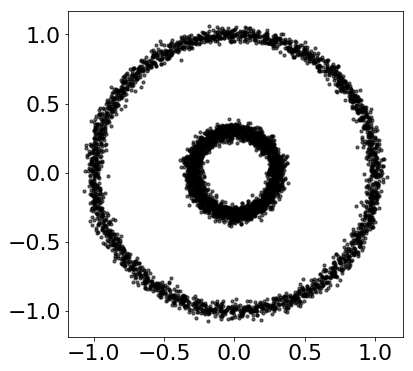

In [3]:
#plot the data to visualise the underlying shape 
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c='k', marker='o', s=10, alpha=0.60)

We can generate an artificial hotspot in the dataset by taking a random sample, and classifying all samples that lie in the radius r of the random sample as the hotspot class. 

In [10]:
y = hmu.generate_artificial_hotspot(X, 0.5, random_seed = 12)

Text(0.5, 1.0, 'Artificial hotspot - 2D Circles')

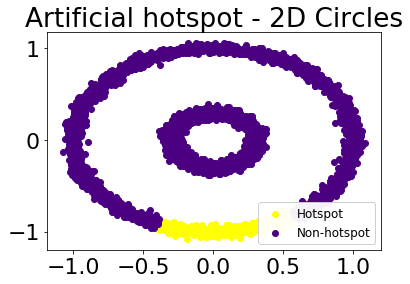

In [11]:
# plot graph with appropriate labels 
# subset dataset to y=1 and y=0 to describe legend 
bool_list = list(map(bool,y))
h_class = X[bool_list]
nh_class = X[~np.array(bool_list)]

h = plt.scatter(h_class[:,0], h_class[:,1], color = 'yellow')
nh = plt.scatter(nh_class[:,0], nh_class[:,1], color = 'indigo')
plt.legend((h, nh),('Hotspot', 'Non-hotspot'),fontsize=12, loc = 4, framealpha =0.95)
plt.title("Artificial hotspot - 2D Circles")

## Build Mapper graph

The workflow for building the Mapper graph on a dataset is as follows:

1. Project the dataset into a low-dimensional space using the *lens* function
2. Build a cover on the lens values. The cover divides the lens function into overlapping intervals 
3. Run a clustering algorithm on the collection of data samples contained within each interval 
4. Construct a graph by representing each cluster as a node 
5. If two clusters contain overlapping samples, define an edge between the corresponding nodes 
6. Colour the graph by an *attribute* function of interest

We can implement the Mapper algorithm using manually selected parameters

Initializing Mapper class...
Projecting data across l2norm lens...
Building cover over lens of 7 intervals with 20.0% overlap
Run clustering algorithm 'AgglomerativeClustering(n_clusters=6)' within across the cover...
Building graph...
Visualising graph...


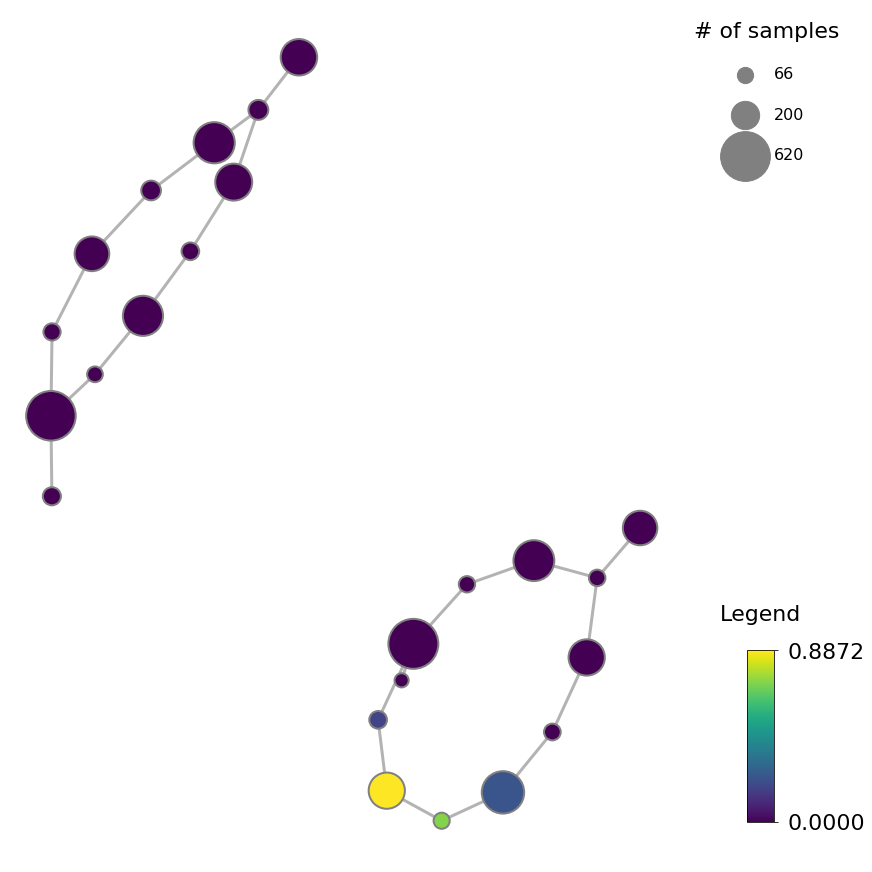

In [16]:
#initialise the mapper class
mapper = hm.Mapper(X)

#Project the dataset across the lens function 
#In this example we select the lens function as "l2norm", the euclidean distance
lens = mapper.lens_function(selection = "l2norm")

# Build a cover on the lens function - specify the number of intervals and the percentage overlap
mapper.covering(intervals = 7, overlap = 0.2)

# Run a clustering algorithm and build the graph 
mapper.cluster_data(algorithm = sklc.AgglomerativeClustering(n_clusters = 6, linkage = "ward"))

#build the graph with edges and nodes 
graph = mapper.build_graph(attribute = y)

#visualise graph 
#colour nodes by the minimum value of each sample within the node
mapper.visualise(size = 4)

##  Run hotspot detection on graph 

We can run the cluster detection and classification steps on the manually created Mapper graph to identify any hotspots of interest



Visualising graph...


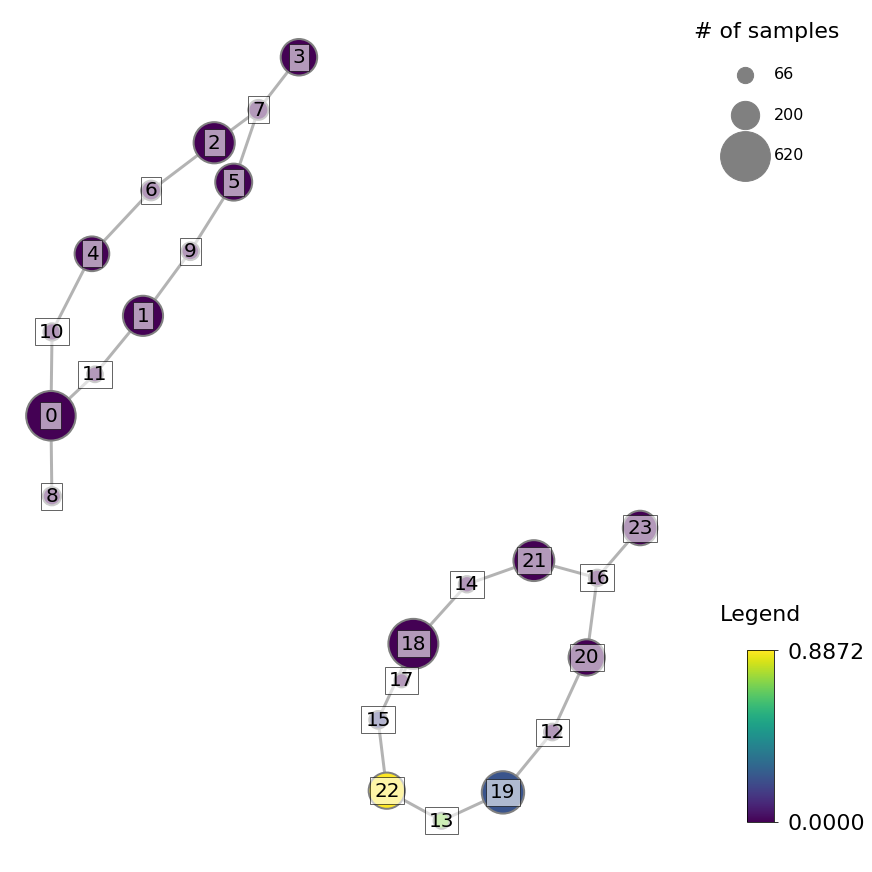

In [17]:
#visualise again to see the labels set for each node 
mapper.visualise(size = 4, labels = True)

Searching for hotspots within the subgraphs...


C:\Users\ciara\anaconda3\envs\clam\lib\site-packages\scipy\cluster\hierarchy.py:2830: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  ax.set_ylim([0, dvw])


<Figure size 432x288 with 0 Axes>

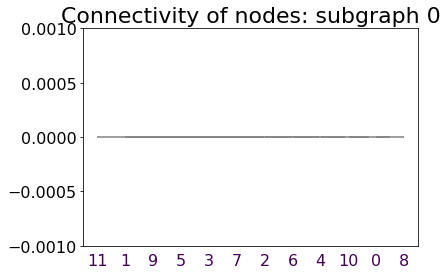

<Figure size 432x288 with 0 Axes>

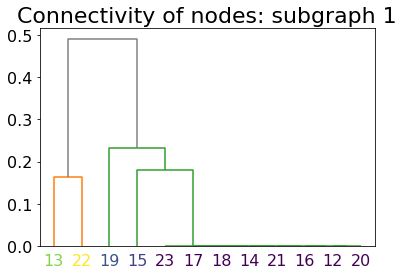

No hotspots present in subgraph 0
Hotspots found in subgraph 1: nodes [[13, 22]]


In [18]:
#investigate each connected subgraph of the mapper graph seperately
graph_components = hmh.Subgraphs(mapper)
hotspots = graph_components.run_hotspot_search(attribute_threshold = 0.5, min_sample_size = 30, dendrogram = True)

In [19]:
# all the results for each subgraph can be found in the hotspot variable 
hotspots

,0,1
component,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}","{12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}"
clusters,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...","[[12, 14, 15, 16, 17, 18, 19, 20, 21, 23], [13..."
mean attribute,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.041, 0.805]"
size,"[614, 403, 424, 333, 301, 342, 97, 99, 82, 78,...","[2178, 368]"
hotspot class,"[False, False, False, False, False, False, Fal...","[False, True]"
neighbourhood nodes,"[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [0, 2, 3...","[[13, 22], [12, 14, 15, 16, 17, 18, 19, 20, 21..."
neighbourhood size,"[1997, 2171, 2145, 2222, 2240, 2217, 2481, 248...","[368, 2178]"
neighbourhood attribute,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.805, 0.041]"
hotspot nodes,[],"[[13, 22]]"


## Searching Lens

Alternatively, the hotspot detection algorithm can be used to automatically select parameters.

This involves the selection of:
- the lens space
- set of intervals
- set of overlap
- clustering algorithm
- attribute function
- epsilon parameter (threshold at which to accept a hotspot)
- minimum sample size for a hotspot


In [66]:
#initialise the search class with the Mapper 
search = hps.Parameter_Search(X, runs = 5)
parameters = {"lens_option" : "linear", 
              "interval_list" : [5,10,15,20,25] ,
              "overlap_list" : [0.4,0.6,0.8],
              "clustering_algorithm" : sklc.DBSCAN(),
              "attribute_function" : y,
              "epsilon" : 0.5,
              'min_samples' : 30}

Initializing Mapper class...


In [21]:
search.build_graphs(parameters)


Hotspots search successful


We can use the information obtained from the hotspot search to build the Mapper graph with the identified lens. We can explore the different representations of the Mapper graph from the successful interval and overlap results

In [25]:
successful_cover = [i for i in search.parameter_io.values()]
print(successful_cover)

[[10, 0.4]]


In [23]:
#initialise the mapper class
mapper = hm.Mapper(X)

#Project the dataset across the lens function 
#In this example we select the lens function as "l2norm", the euclidean distance
lens = mapper.lens_function(selection = parameters["lens_option"], r = search.mapper.random_value)

Initializing Mapper class...
Projecting data across linear lens...


Building cover over lens of 25 intervals with 80.0% overlap
Run clustering algorithm 'AgglomerativeClustering(n_clusters=6)' within across the cover...
Building graph...
Visualising graph...


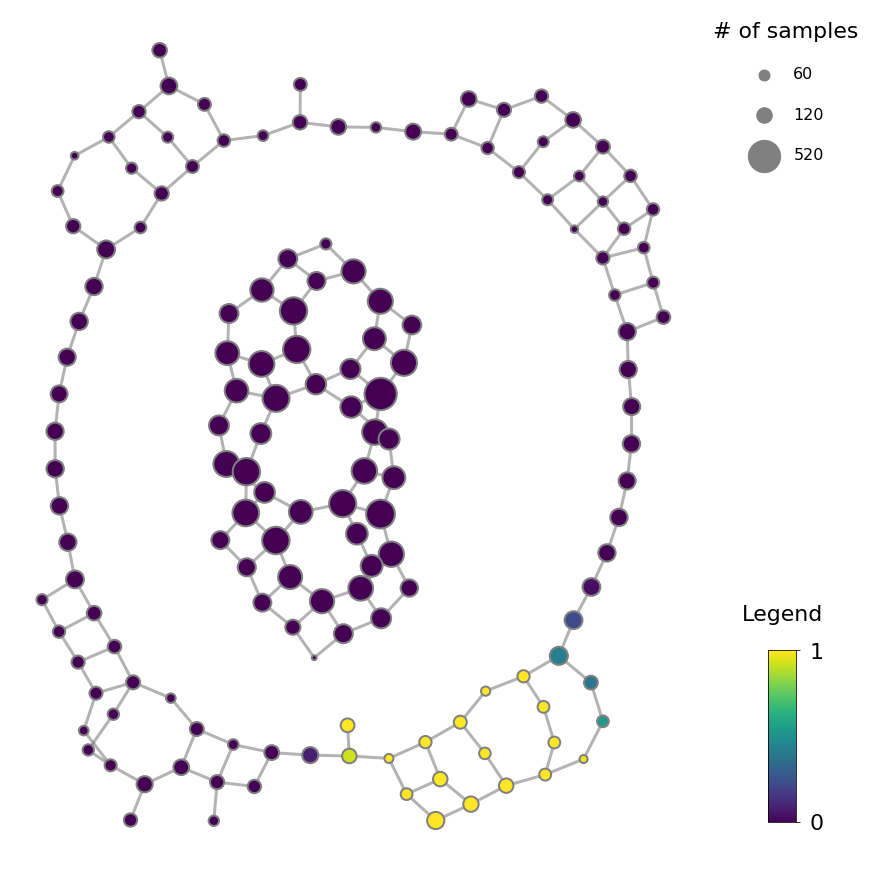

Searching for hotspots within the subgraphs...
Hotspots found in subgraph 0: nodes [[129, 130, 133, 134, 137, 139, 141, 143, 144, 111, 116, 117, 148, 120, 121, 125, 127]]
No hotspots present in subgraph 1


In [38]:
# Build a cover on the lens function - specify the number of intervals and the percentage overlap
mapper.covering(intervals = 25, overlap = 0.8)

# Run a clustering algorithm and build the graph 
mapper.cluster_data(algorithm = sklc.AgglomerativeClustering(n_clusters = 6, linkage = "ward"))

#build the graph with edges and nodes 
graph = mapper.build_graph(attribute = y)

#visualise graph 
#colour nodes by the minimum value of each sample within the node
mapper.visualise(size = 2, style = 2, labels = False)

#investigate each connected subgraph of the mapper graph seperately
graph_components = hmh.Subgraphs(mapper)
hotspots = graph_components.run_hotspot_search(attribute_threshold = 0.1, min_sample_size = 30, dendrogram = False)

In [39]:
hotspots

,0,1
component,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","{32, 36, 37, 43, 45, 46, 48, 51, 52, 53, 54, 5..."
clusters,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[[88], [32], [94], [36], [95], [37], [105], [4..."
mean attribute,"[0.02, 0.994]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
size,"[2176, 406]","[281, 62, 239, 292, 162, 178, 200, 314, 179, 2..."
hotspot class,"[False, True]","[False, False, False, False, False, False, Fal..."
neighbourhood nodes,"[[111, 116, 117, 120, 121, 125, 127, 129, 130,...","[[32, 36, 37, 43, 45, 46, 48, 51, 52, 53, 54, ..."
neighbourhood size,"[406, 2176]","[2500, 2500, 2500, 2500, 2500, 2500, 2500, 250..."
neighbourhood attribute,"[0.994, 0.02]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
hotspot nodes,"[[129, 130, 133, 134, 137, 139, 141, 143, 144,...",[]


In [91]:
np.savetxt("r.txt", search.mapper.random_value, delimiter=",")
np.savetxt("cover.txt",successful_cover, delimiter = ",")

In [92]:
keys = ['lens_option', 'clustering_algorithm', 'epsilon', 'min_samples']

search_description = []
for n_key in keys:
    search_description.append([n_key, str(parameters[n_key])])

np.savetxt("parameters.txt",search_description, delimiter = ",", fmt='%s')

To recreate the same graph in the future, the "r" file needs to be saved. This assigns the random weightings to the dataset to generate a linear combination of the features, generating the successful lens function

In [40]:
r = np.loadtxt("example_r.txt")

Initializing Mapper class...
Projecting data across linear lens...
Building cover over lens of 25 intervals with 80.0% overlap
Run clustering algorithm 'AgglomerativeClustering(n_clusters=6)' within across the cover...
Building graph...
Visualising graph...


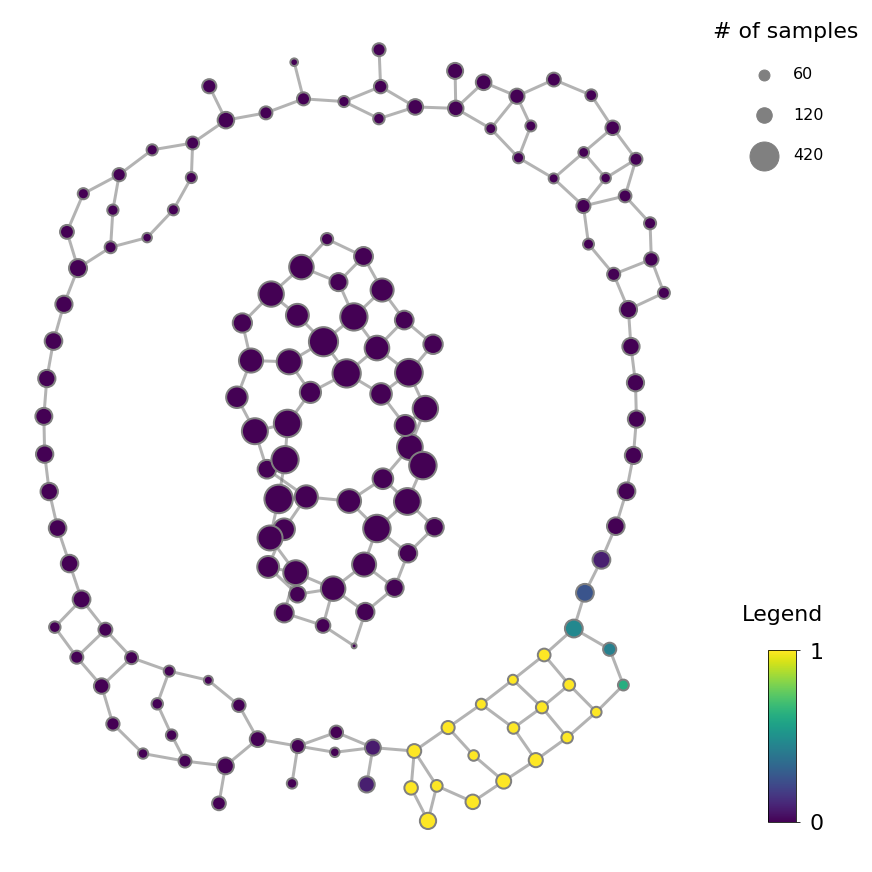

Searching for hotspots within the subgraphs...
Hotspots found in subgraph 0: nodes [[129, 130, 133, 134, 137, 140, 141, 111, 143, 145, 115, 116, 148, 121, 123, 124, 126]]
No hotspots present in subgraph 1


In [42]:
#initialise the mapper class
mapper = hm.Mapper(X)

#Project the dataset across the lens function 
#In this example we select the lens function as "l2norm", the euclidean distance
lens = mapper.lens_function(selection = "linear", r = r)

# Build a cover on the lens function - specify the number of intervals and the percentage overlap
mapper.covering(intervals = 25, overlap = 0.8)

# Run a clustering algorithm and build the graph 
mapper.cluster_data(algorithm = sklc.AgglomerativeClustering(n_clusters = 6, linkage = "ward"))

#build the graph with edges and nodes 
graph = mapper.build_graph(attribute = y)

#visualise graph 
#colour nodes by the minimum value of each sample within the node
mapper.visualise(size = 2, style = 2, labels = False)

#investigate each connected subgraph of the mapper graph seperately
graph_components = hmh.Subgraphs(mapper)
hotspots = graph_components.run_hotspot_search(attribute_threshold = 0.1, min_sample_size = 30, dendrogram = False)